In [1]:
#Global variables
import socket
import os
ENV_HOSTNAME = socket.gethostname()
print('ENV_HOSTNAME:' + ENV_HOSTNAME)

#store defaults for Jacob here:
ENV_FOLDER_DATA = 'C:\\Users\\jakes\\Documents\\COMS 4732 - Computer Vision\\W4732CompVisFinal\\Data\\'
ENV_FOLDER_DATA_PROC = 'C:\\Users\\jakes\\Documents\\COMS 4732 - Computer Vision\\W4732CompVisFinal\\Data_Proc\\'
ENV_PRATT = ''


if ENV_HOSTNAME == 'JWGamingPC':
    ENV_FOLDER_DATA = 'E:\\W4732 Computer Vision\\Final Paper Data\\'
    ENV_FOLDER_DATA_PROC = 'E:\\W4732 Computer Vision\\Final Paper Data Proc\\'
    ENV_PRATT = ''

ENV_HOSTNAME:The-Beast


In [2]:
#Global variables
import cv2
import numpy as np
import matplotlib.pyplot as plt

def preprocess_video(video_path, desired_fps=10, target_resolution=(640, 360)):
    cap = cv2.VideoCapture(video_path)
    frames = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frame = cv2.resize(frame, target_resolution)
        frames.append(frame)

    cap.release()

    frame_interval = int(10 / desired_fps)
    sampled_frames = frames[::frame_interval]

    video_data = np.array(sampled_frames)
    video_data = video_data / 255.0

    
    # video_data = np.expand_dims(video_data, axis=-1)

    if video_data.shape[0] < 40:
        # Pad the video data with zeros to make it at least 40 frames long
        padding = np.zeros((40 - video_data.shape[0], video_data.shape[1], video_data.shape[2]))
        video_data = np.concatenate((video_data, padding), axis=0)
    elif video_data.shape[0] > 40:
        # Trim the video data to be exactly 40 frames long
        video_data = video_data[:40]
    
    return video_data

# Example usage:
# video_path = ENV_FOLDER_DATA_PROC + 'clips\\501\\501_524_528.mp4'
# preprocessed_data = preprocess_video(video_path)
# print("Preprocessed video data shape:", preprocessed_data.shape)

# video_dir = ENV_FOLDER_DATA_PROC + 'clips\\595\\'

# for video in os.listdir(video_dir):
#     video_path = video_dir + video
#     preprocessed_data = preprocess_video(video_path)
#     display_frame = np.vstack(preprocessed_data)

#     plt.imshow(display_frame, cmap='gray')
#     plt.axis('off')
#     plt.show()
#     # # display frames
#     # for frame in preprocessed_data:
#     #     cv2.imshow('frame', frame)
#     # break
#     #print("Preprocessed video data shape:", preprocessed_data.shape)

81856


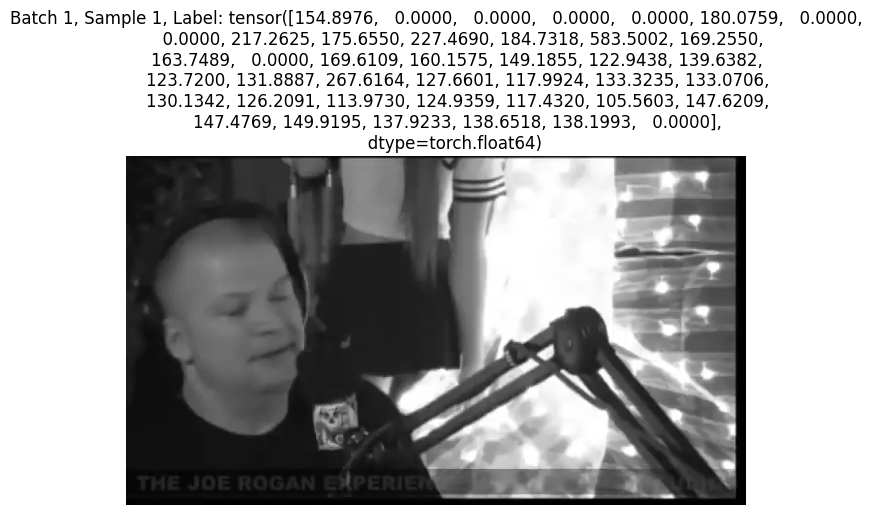

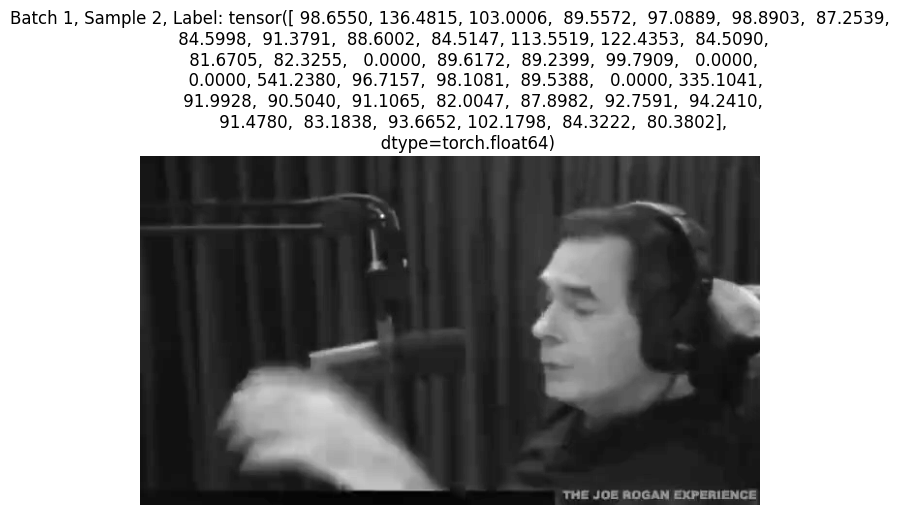

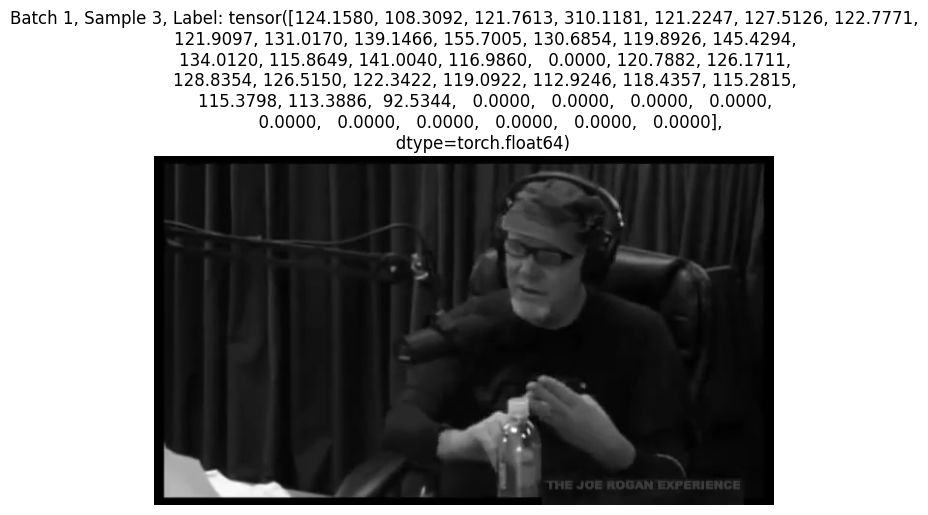

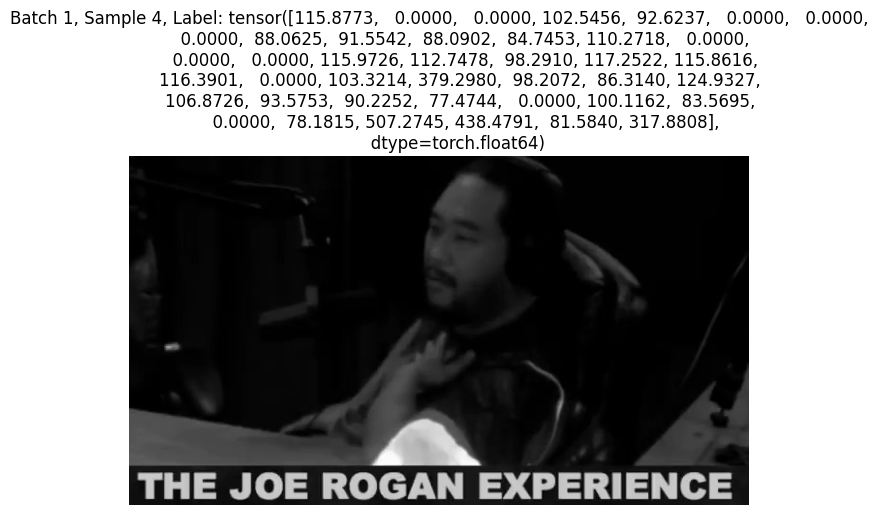

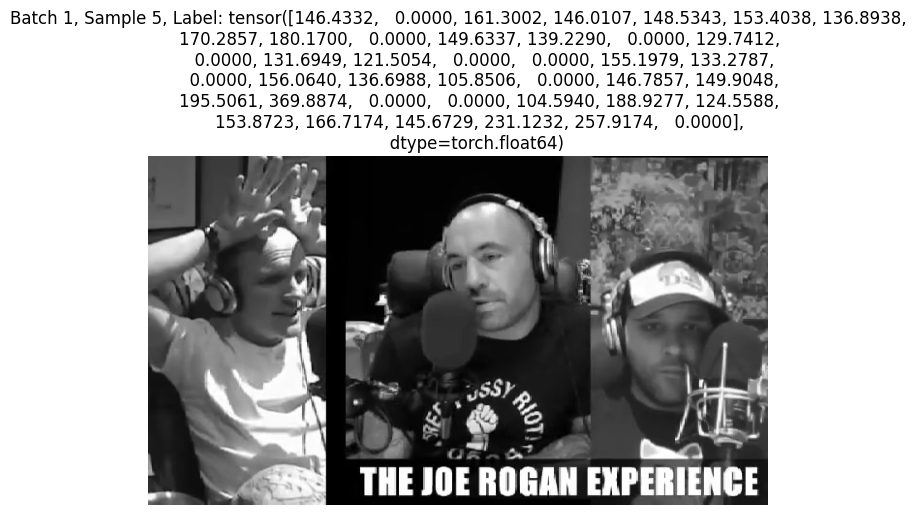

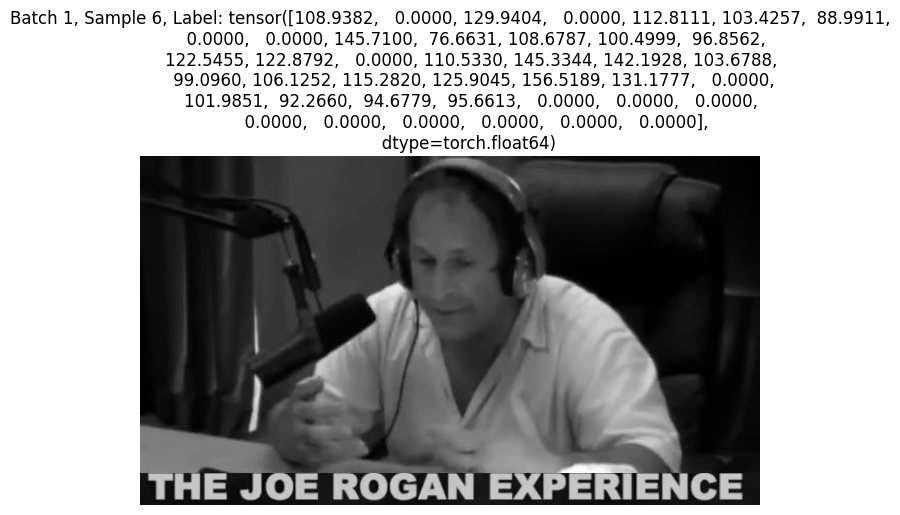

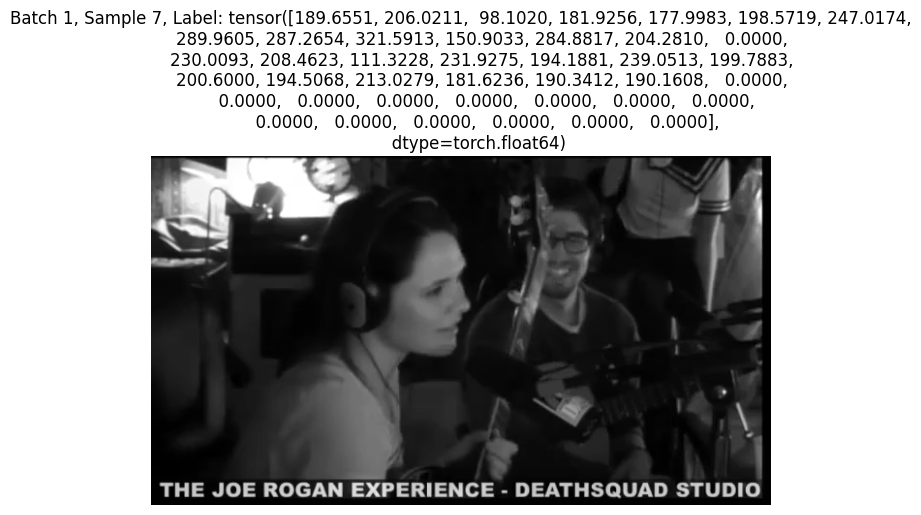

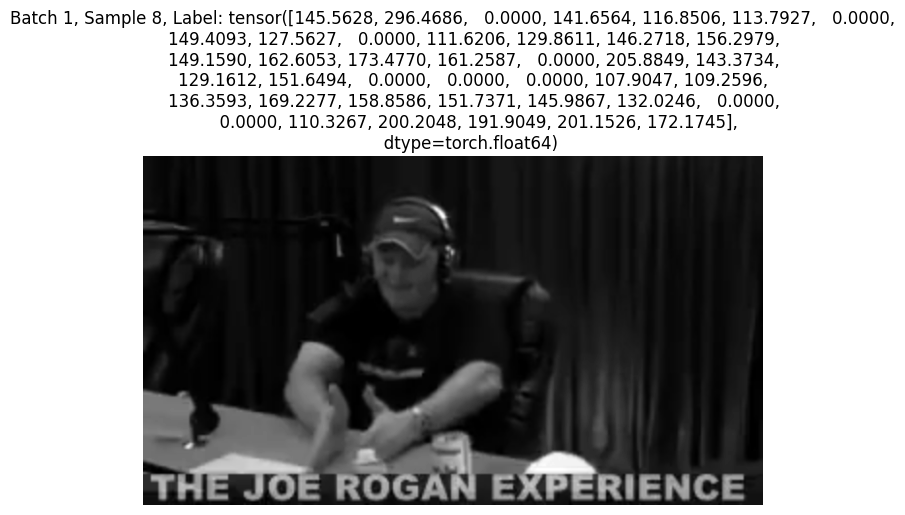

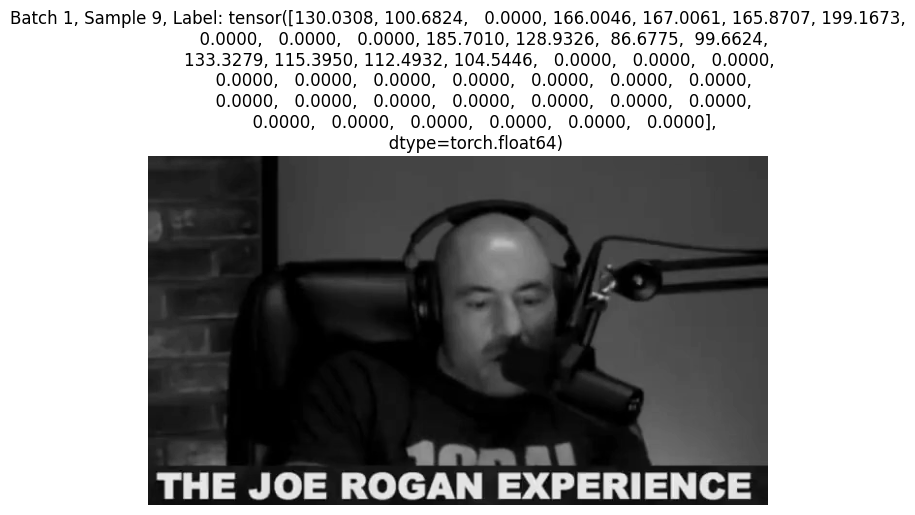

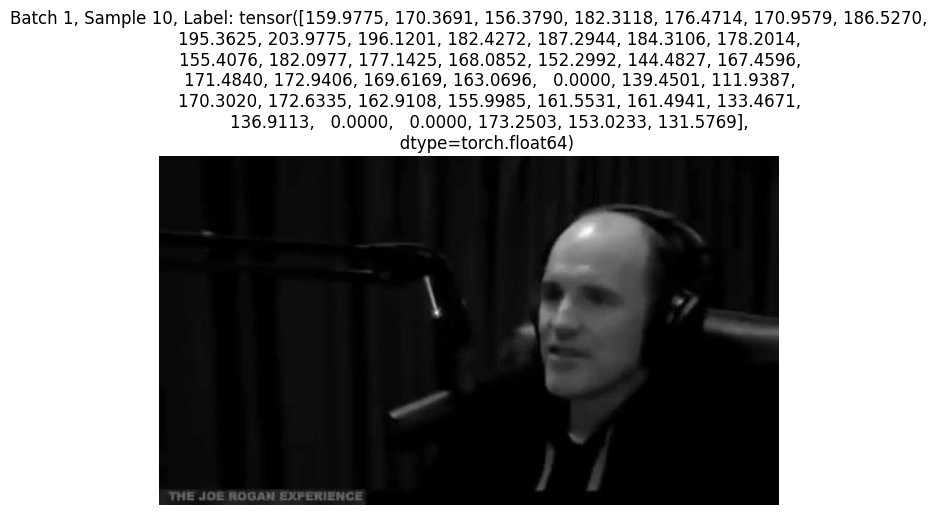

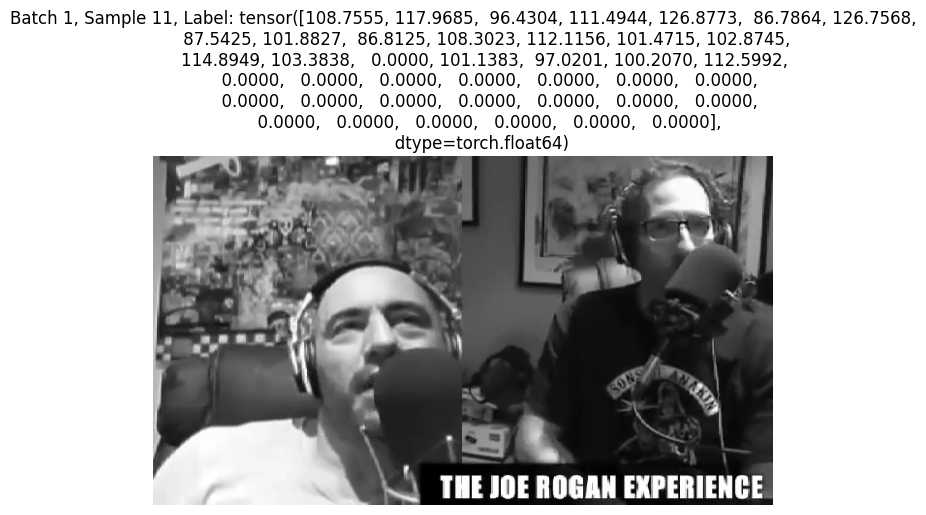

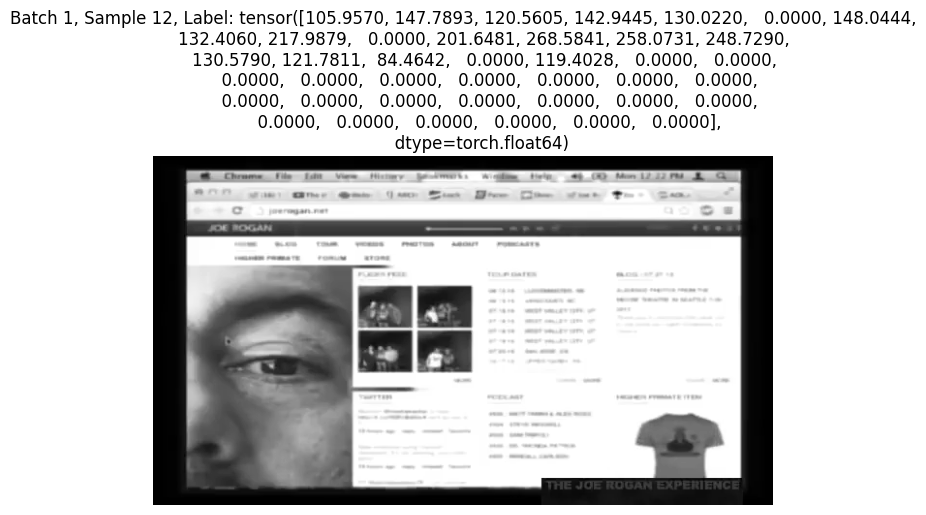

In [3]:
# Create the Data loader

import torch
from torch.utils.data import Dataset
import cv2
import numpy as np
import pandas as pd

class VideoDataset(Dataset):
    def __init__(self, video_paths, desired_fps=10, target_resolution=(640, 360), label_type='p'):
        self.video_paths = video_paths
        self.desired_fps = desired_fps
        self.target_resolution = target_resolution
        self.label_type = label_type

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        video_data = preprocess_video(video_path, self.desired_fps, self.target_resolution)
        video_data = np.expand_dims(video_data, axis=0)

        features = torch.tensor(video_data, dtype=torch.float32)
        episode_number = video_path.split('\\')[-2]
        seg_number = video_path.split('_seg')[-1].split('.')[0]
        pickle_path = ENV_FOLDER_DATA_PROC + 'targetdf\\' + episode_number + '.pickle'
        target_df = pd.read_pickle(pickle_path)

        #find row where seg number is equal to seg number and type is equal to label type
        target_row = target_df[(target_df['seg'] == int(seg_number)) & (target_df['type'] == self.label_type)]

        #extract the data from columns 3:43

        audio_data = target_row.iloc[:, 4:45].values

        labels = torch.tensor(audio_data.astype(float).flatten())
        
        labels = torch.nan_to_num(labels)

        # if len(features) != 40 or len(labels) != 41:
        #     #print(episode_number, seg_number, len(features), len(labels))
        #     #write to ENV_FOLDER_DATA_PROC + 'invalid_vid_paths.txt'
        #     with open(ENV_FOLDER_DATA_PROC + 'invalid_vid_paths.txt', 'a') as f:
        #         f.write(video_path + '\n')
            
        #     labels = torch.zeros(41)

        return features, labels


from torch.utils.data import DataLoader

clips_dir = ENV_FOLDER_DATA_PROC + 'clips\\'
# Example usage
video_paths = []


for root, dirs, files in os.walk(clips_dir):
    for file in files:
        if file.endswith(".mp4"):
            video_paths.append(os.path.join(root, file))


training_paths = video_paths[:int(len(video_paths) * 0.8)]
test_paths = video_paths[int(len(video_paths) * 0.8):]

training_dataset = VideoDataset(training_paths)
test_dataset = VideoDataset(test_paths)

training_dataloader = DataLoader(training_dataset, batch_size=12, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=12, shuffle=True)


# dataset = VideoDataset(video_paths)
# # discard all data points that are None,None
# #dataset = [data for data in dataset if data != (None, None)]
# dataloader = DataLoader(dataset, batch_size=128, shuffle=True)


print(len(training_dataset))
# Iterate over batches
for batch_idx, (data, labels) in enumerate(training_dataloader):
    # 'data' will have shape (batch_size, 1, 40, 640, 360)
    # We can extract the first frame (index 0 along the frame dimension)
    first_frame_batch = data[:, 0, 0]

    # Iterate through each sample in the batch
    for i in range(len(first_frame_batch)):
        # Get the first frame of the sample and its corresponding label
        first_frame = first_frame_batch[i]
        label = labels[i]

        # Convert the torch tensor to a numpy array and transpose dimensions
        # Assuming the tensor is in (channel, depth, height, width) format
        first_frame_np = first_frame.numpy()

        # Display the first frame using matplotlib
        plt.figure(figsize=(8, 6))
        plt.imshow(first_frame_np.squeeze(), cmap='gray')  # Squeeze out the channel dimension
        plt.title(f'Batch {batch_idx + 1}, Sample {i + 1}, Label: {label}')
        plt.axis('off')
        plt.show()

    # Only display the first batch
    break



In [4]:
import os
import shutil

def move_files_to_folder(file_list_path, destination_folder):
    # Create the destination folder if it doesn't exist
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    # Read the list of file paths from the text file
    with open(file_list_path, 'r') as file:
        file_paths = file.readlines()

    # Remove leading/trailing whitespaces and newline characters
    file_paths = [path.strip() for path in file_paths]

    # Move each file to the destination folder
    for file_path in file_paths:
        if os.path.exists(file_path):  # Check if file exists
            file_name = os.path.basename(file_path)
            destination_path = os.path.join(destination_folder, file_name)
            shutil.move(file_path, destination_path)
            print(f"Moved '{file_path}' to '{destination_path}'")
        else:
            print(f"File '{file_path}' not found.")

# Example usage:
# file_list_path = ENV_FOLDER_DATA_PROC + 'invalid_vid_paths.txt'  # Path to the text file containing the list of file paths
# destination_folder = ENV_FOLDER_DATA_PROC + 'invalid_clips\\'  # Destination folder to move the files to
# move_files_to_folder(file_list_path, destination_folder)

In [5]:
#Code to test hypotheses

# 2 Layers of 3D CONV
# 3 Layers of 2D CONV
# Max pooling after each layer
# Batch normalization after each layer
# Flatten
# 3 Fully connected layers

# Leaky ReLU activation function

# adam optimizer
# Loss Function: Cross Entropy

import torch.nn as nn
import torch.nn.functional as F


class VideoConvNet(nn.Module):
    def __init__(self, in_channels=1, num_classes=41):
        super().__init__()
        # TODO: Initialize network layers
        
        self.layer1 = nn.Sequential(
            nn.Conv3d(in_channels=in_channels, out_channels=8, kernel_size=3, padding=1),
            nn.BatchNorm3d(8),
            nn.LeakyReLU(),
            nn.MaxPool3d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv3d(in_channels=8, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm3d(32),
            nn.LeakyReLU(),
            nn.MaxPool3d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv3d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm3d(64),
            nn.LeakyReLU(),
            nn.MaxPool3d(kernel_size=2, stride=2))
        # self.layer4 = nn.Sequential(
        #     nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
        #     nn.BatchNorm2d(128),
        #     nn.LeakyReLU(),
        #     nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc1 = nn.Sequential(
            nn.Linear(1152000, 256),
            nn.LeakyReLU(),
            nn.Dropout(0.5))
        self.fc2 = nn.Sequential(
            nn.Linear(256, 128),
            nn.LeakyReLU(),
            nn.Dropout(0.5))
        self.fc3 = nn.Sequential(
            nn.Linear(128, num_classes))
        







    def forward(self, x):
        # TODO: Implement the forward pass with using the layers defined above
        #       and the proper activation functions
        #print("input: ", x.shape)
        x = self.layer1(x)
        #print("layer1: ", x.shape)
        x = self.layer2(x)
        #print("layer2: ", x.shape) 
        x = self.layer3(x)
        #print("layer3: ", x.shape)
        #x = self.layer4(x)
        #print("layer4: ", x.shape)
        x = x.view(x.size(0), -1)
        #print("flatten: ", x.shape)
        x = self.fc1(x)
        #print("fc1: ", x.shape)
        x = self.fc2(x)
        #print("fc2: ", x.shape)
        x = self.fc3(x)
        #print("fc3: ", x.shape)
        return x

vidNet = VideoConvNet()





In [6]:
# # Assuming you have a CUDA-enabled GPU
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Move the model to the GPU
# vidNet.to(device)

# # Loss function and optimizer
# import torch.optim as optim
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(vidNet.parameters(), lr=0.01)

# # Training the network
# num_epochs = 10

# for epoch in range(num_epochs):
#     running_loss = 0.0
#     for i, data in enumerate(training_dataloader, 0):
#         inputs, labels = data
#         inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU

#         optimizer.zero_grad()

#         outputs = vidNet(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()
#         if i % 10 == 9:
#             print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 10}")
#             running_loss = 0.0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vidNet.parameters(), lr=0.001)
def train_network(net, n_epochs=2):
    net.to(device)

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        for i, data in enumerate(training_dataloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            #print(outputs)
            loss = criterion(outputs, labels)
            loss.backward()
                        # After the backward pass
            # for name, param in vidNet.named_parameters():
            #     if param.requires_grad and param.grad is not None:
            #         print(f'Parameter: {name}, Gradient norm: {param.grad.norm()}')
            optimizer.step()

            # print statistics
            if i % 10 == 0:
                print(f'Epoch={epoch + 1} Iter={i + 1:5d} Loss={loss.item():.3f}')
                running_loss = 0.0
    print('Finished Training')
    return net

C:\Users\jakes\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
train_network(vidNet, n_epochs=2)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (12x1152000 and 1156000x256)

In [ ]:
#print rows of pickle

video_path = ENV_FOLDER_DATA_PROC + 'clips\\595\\595_seg1434.mp4'
#video_path = ENV_FOLDER_DATA_PROC + 'clips\\542\\542_seg1963.mp4'

label_type = 'p'    
episode_number = video_path.split('\\')[-2]
seg_number = video_path.split('_seg')[-1].split('.')[0]
pickle_path = ENV_FOLDER_DATA_PROC + 'targetdf\\' + episode_number + '.pickle'
target_df = pd.read_pickle(pickle_path)

#find row where seg number is equal to seg number and type is equal to label type
#print(target_df)
target_row = target_df[(target_df['seg'] == int(seg_number)) & (target_df['type'] == label_type)]
#print(target_row)

#extract the data from columns 3:43

audio_data = target_row.iloc[:, 4:].values


# print(episode_number,seg_number, pickle_path, label_type)
print(audio_data)


#replace all nan values with 0


labels = torch.tensor(audio_data.astype(float).flatten())

# print(audio_data.shape)
# print(audio_data.flatten())
# print(audio_data.flatten().shape)

labels = torch.nan_to_num(labels)

print(labels)

